In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
# Add the path to the utils directory
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from import_funcs import * #list_files_with_extension, extract_data_inline
from calibration_funcs import * 
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from plotting_funcs import plot_all_conditions, plot_condition_classes


In [3]:
path = './data'
txt_files = list_files_with_extension(path, '.txt')

# Add a 'time_index' column before concatenating all_X
all_X = []

for file in txt_files:
    # Extract condition (text after last underscore, before .txt)
    condition = Path(file).stem.split(' ')[-1]
    # Extract data
    idx_start, idx_stop, delta_time, T, X_local = extract_data_inline(file)
    # Drop unwanted columns
    X_local = X_local.drop(columns=['power'])
    # Add time_index column
    X_local = X_local.copy()
    X_local['time_index'] = X_local.index
    # Add condition column
    X_local['condition'] = condition
    all_X.append(X_local)

all_X = pd.concat(all_X, ignore_index=True)

In [4]:
all_X.condition.unique()

array(['50'], dtype=object)

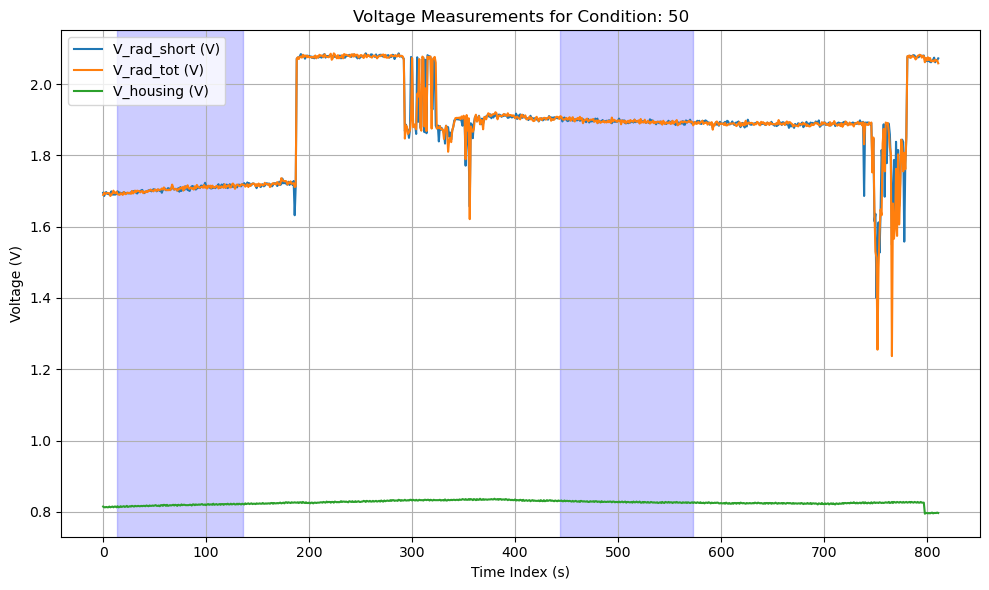

In [5]:
variables = ['V_rad_short', 'V_rad_tot', 'V_housing']
labels = {
    'V_rad_short': 'V_rad_short (V)',
    'V_rad_tot': 'V_rad_tot (V)',
    'V_spike': 'V_spike (V)',
    'V_housing': 'V_housing (V)',
    'V_diode': 'V_diode (V)'
}

for cond in all_X['condition'].unique():
    subset = all_X[all_X['condition'] == cond]
    plt.figure(figsize=(10, 6))
    for var in variables:
        plt.plot(subset.time_index, subset[var] / 1000, label=labels[var])
    cooling_periods = subset[subset['cooling_flag_1'] == 1]
    if not cooling_periods.empty:
        # Group consecutive periods
        cooling_periods = cooling_periods.copy()
        cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
        for _, group in cooling_periods.groupby('group'):
            start = group['time_index'].min()
            end = group['time_index'].max()
            plt.axvspan(start, end, color='blue', alpha=0.2)
    plt.title(f"Voltage Measurements for Condition: {cond}")
    plt.xlabel("Time Index (s)")
    plt.ylabel("Voltage (V)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
# Assign 'class' labels for each condition separately
all_X['class'] = None

for cond in all_X['condition'].unique():
    cond_mask = all_X['condition'] == cond
    cond_df = all_X[cond_mask]
    cooling_periods = cond_df[cond_df['cooling_flag_1'] == 1].copy()
    cooling_periods['group'] = (cooling_periods['time_index'].diff() != 1).cumsum()
    periods = cooling_periods.groupby('group')['time_index'].agg(['first', 'last']).reset_index(drop=True)
    # Use labels list, repeat if needed
    labels_25 = []
    labels_50 = ["load", "antenna"]
    if cond == "25":
        cond_labels = labels_25 * ((len(periods) + len(labels_25) - 1) // len(labels_25))
    elif cond == "50":
        cond_labels = labels_50 * ((len(periods) + len(labels_50) - 1) // len(labels_50))
    else:
        raise ImportError("Unknown condition")
    periods['label'] = cond_labels[:len(periods)]
    for _, row in periods.iterrows():
        mask = cond_mask & (all_X['time_index'] >= row['first']) & (all_X['time_index'] <= row['last'])
        all_X.loc[mask, 'class'] = row['label']

for cond in all_X['condition'].unique():
    print(f"\nCondition: {cond}")
    print(all_X[all_X['condition'] == cond]['class'].value_counts(dropna=False))



Condition: 50
class
None       558
antenna    130
load       124
Name: count, dtype: int64


In [7]:
# Filter out classes with asterisks and get valid classes for each condition
all_X_clean = all_X[~all_X['class'].str.contains(r'\*', na=False)].copy()

# Remove rows where class is None
all_X_clean = all_X_clean[all_X_clean['class'].notna()].copy()

print("Valid classes by condition:")
conditions = sorted(all_X_clean['condition'].unique())

for cond in conditions:
    print(f"\nCondition: {cond}")
    print(all_X_clean[all_X_clean['condition'] == cond]['class'].value_counts())

Valid classes by condition:

Condition: 50
class
antenna    130
load       124
Name: count, dtype: int64



Condition 50 - Data summary by class:
  load: 124 points, time range: 0.0 - 123.0 s
  antenna: 130 points, time range: 144.0 - 273.0 s


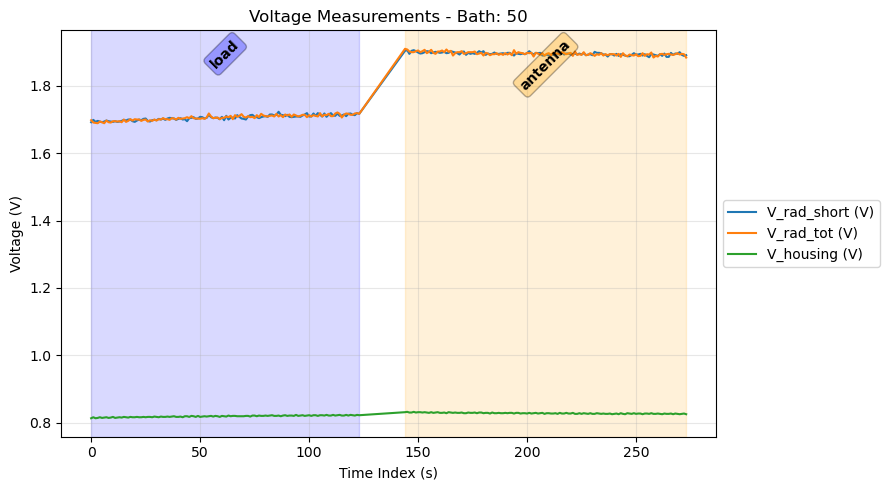

<Figure size 640x480 with 0 Axes>

In [8]:
class_order = ['load', 'antenna']
class_colors = {
    'load': 'blue',
    'antenna': 'orange'
}
variables = ['V_rad_short', 'V_rad_tot', 'V_housing']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1000,
    title_prefix="Voltage Measurements - Bath: ",
    ylabel="Voltage (V)"
)

In [9]:
# Calculate average V_rad_tot and V_housing for each condition and class
print("Average voltages by condition and class:")
print("="*50)

for condition in conditions:
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_voltages = condition_data.groupby('class')[['V_rad_tot', 'V_housing']].mean()
    
    print("Microvolts:")
    print(avg_voltages.round(1))
    print("-" * 30)

Average voltages by condition and class:

Condition: 50
Microvolts:
         V_rad_tot  V_housing
class                        
antenna     1895.8      827.9
load        1705.8      818.9
------------------------------


In [10]:
# Define calibration parameters as variables
RadSlopeChange = 0.0006182511106682944  # V/°C²
RadSlope0 = -0.06051481175395883        # V/°C
RadOffsetChange = -0.0009632383570051569 # V/°C
RadOffset0 = 0.2300154917793174         # V
HousingSlope = 98.08555780332561        # °C/V
HousingOffset = -49.81626782454236      # °C

In [ ]:
vna_excel_path = Path("/Users/mcy/Library/CloudStorage/OneDrive-HEPTAMEDICAL/HEPTA ADMIN - presentation_Manuel/VNA/VNA Measurements.xlsx")
vna_data = pd.read_excel(vna_excel_path)

date = "Aug 27 2025"
tau_antenna_in_dB = vna_data[(vna_data['DUT'] == 'Antenna') & (vna_data["Date"] == date)]['S11 Mod (dB)'].values[0] / 2
tau_antenna = 10**(tau_antenna_in_dB/10)
print(f"Antenna measured S21: {tau_antenna_in_dB:.3f}")
print(f"Antenna measured transmission: {tau_antenna:.3f}")
antenna_l = 40 # cm
antenna_l_in_feet = antenna_l / 30.48
tau_antenna_in_dB_theoretical = -0.8879088 * antenna_l_in_feet
tau_antenna_theoretical = 10**(tau_antenna_in_dB_theoretical/10)
print(f"Antenna theoretical S21: {tau_antenna_in_dB_theoretical:.3f}")
print(f"Antenna theoretical transmission: {tau_antenna_theoretical:.3f}")

Antenna measured S21: -1.708
Antenna measured transmission: 0.675
Antenna theoretical S21: -1.165
Antenna theoretical transmission: 0.765


In [16]:
tau_antenna = tau_antenna_theoretical
tau_handle = 10**((tau_antenna_in_dB - tau_antenna_in_dB_theoretical)/10)

In [ ]:
print(class_order)
for cond in conditions:
    print(cond, all_X_clean[all_X_clean['condition'] == cond]['class'].unique())

['load', 'antenna']
50 ['load' 'antenna']


In [21]:
def T_tissue_antenna_and_handle(T_rad, T_antenna, T_handle, tau_antenna, tau_handle):
    T_tissue = (T_rad - T_antenna*tau_handle*(1-tau_antenna) - T_handle*(1-tau_handle))/(tau_antenna * tau_handle)
    return T_tissue

In [22]:
for cond in conditions:
    for class_name in class_order:
        mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == class_name)
        class_data = all_X_clean[mask]
        V_rad_tot = class_data['V_rad_tot'] / 1000
        V_housing = class_data['V_housing'] / 1000

        T_housing = T_housing_func(V_housing, HousingSlope, HousingOffset)
        T_rad = T_rad_func(V_rad_tot, T_housing, RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)

        if class_name == "load":
            T_cable = None
            T_tissue = T_rad
            T_antenna = None
            T_handle = None
        elif class_name == "antenna":
            T_antenna = 50
            T_handle = 27
            T_tissue = T_tissue_antenna_and_handle(T_rad, T_antenna, T_handle, tau_antenna, tau_handle)

        all_X_clean.loc[mask, 'T_rad'] = T_rad
        all_X_clean.loc[mask, 'T_tissue'] = T_tissue
        all_X_clean.loc[mask, 'T_housing'] = T_housing
        all_X_clean.loc[mask, 'T_antenna'] = T_antenna
        all_X_clean.loc[mask, 'T_handle'] = T_handle



Condition 50 - Data summary by class:
  load: 124 points, time range: 0.0 - 123.0 s
  antenna: 130 points, time range: 144.0 - 273.0 s


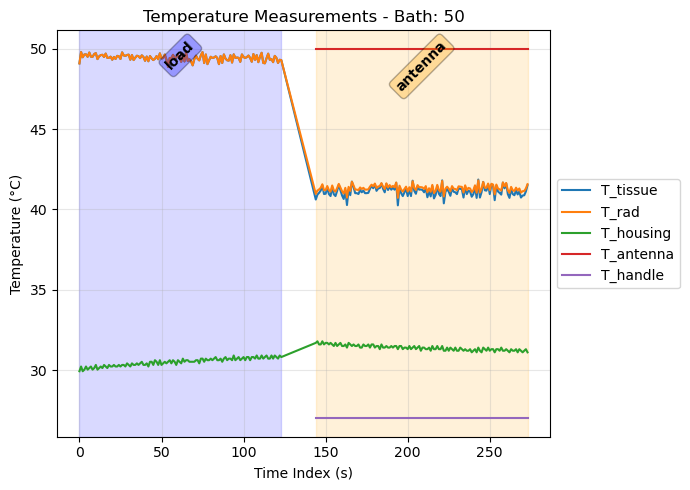

<Figure size 640x480 with 0 Axes>

In [33]:
variables = ['T_tissue', 'T_rad', 'T_housing', 'T_antenna', 'T_handle']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1,
    title_prefix="Temperature Measurements - Bath: ",
    ylabel="Temperature (°C)"
)

In [20]:
# Calculate average Temperature for each condition and class
print("Average temperatures by condition and class:")
print("="*50)

for condition in sorted(all_X_clean['condition'].unique()):
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_temperatures = condition_data.groupby('class')[['T_rad', 'T_housing', 'T_tissue']].mean()

    print("Microvolts:")
    print(avg_temperatures.round(1))
    print("-" * 30)

Average temperatures by condition and class:

Condition: 50
Microvolts:
         T_rad  T_housing  T_tissue
class                              
antenna   41.3       31.4      10.5
load      49.4       30.5      49.4
------------------------------


In [30]:
def T_tissue_antenna_and_handle(T_rad, T_antenna, T_handle, tau_antenna, tau_handle):
    T_tissue = (T_rad - T_antenna*tau_handle*(1-tau_antenna) - T_handle*(1-tau_handle))/(tau_antenna * tau_handle)
    print("T_rad:", T_rad)
    print("T_antenna:", T_antenna)
    print("T_handle:", T_handle)
    print("tau antenna:", tau_antenna)
    print("tau handle:", tau_handle)
    print("T_antenna * tau_handle * (1 - tau_antenna):", T_antenna * tau_handle * (1 - tau_antenna))
    print("T_handle * (1 - tau_handle):", T_handle * (1 - tau_handle))
    print("tau_handle * (1 - tau_antenna):", tau_handle * (1 - tau_antenna))
    print("(1 - tau_handle):", (1 - tau_handle))
    print("T_tissue:", T_tissue)
    return T_tissue

T_t = T_tissue_antenna_and_handle(avg_temperatures.loc["antenna","T_rad"], T_antenna=50, T_handle=24, tau_antenna=tau_antenna, tau_handle=tau_handle)

T_rad: 41.31757155971723
T_antenna: 50
T_handle: 24
tau antenna: 0.7646743726071411
tau handle: 0.882619390947178
T_antenna * tau_handle * (1 - tau_antenna): 10.385148096187384
T_handle * (1 - tau_handle): 2.817134617267728
tau_handle * (1 - tau_antenna): 0.20770296192374765
(1 - tau_handle): 0.117380609052822
T_tissue: 41.65743733182419


## Derive Transmissions from radiometric values

$$
T_{\text{rad}} = T_{\text{bath}} \cdot \tau + T_{\text{DUT}} \cdot (1 - \tau)
$$

$$
\tau = \frac{T_{\text{rad}} - T_{\text{DUT}}}{T_{\text{bath}} - T_{\text{DUT}}}
$$


In [120]:
# tau = (T_cable - T_rad) / (T_cable - T_bath)
T_bath = 50
T_cable = 25

tau_cable_derived = (T_cable - avg_temperatures.loc["cable", "T_rad"]) / (T_cable - T_bath)
# tau_diplexer_derived = (T_cable - avg_temperatures.loc["diplexer (no connector)", "T_rad"]) / (T_cable - T_bath)
tau_diplexer_connector_derived = (T_cable - avg_temperatures.loc["diplexer", "T_rad"]) / (T_cable - T_bath)
tau_diplexer_connector_cable_derived = (T_cable - avg_temperatures.loc["diplexer + cable", "T_rad"]) / (T_cable - T_bath)

print(f"tau_cable_derived: {tau_cable_derived:.4f} ({100*(tau_cable_derived-tau_cable)/tau_cable:.2f}% vs original)")
# print(f"tau_diplexer_derived: {tau_diplexer_derived:.4f} ({100*(tau_diplexer_derived-tau_diplexer)/tau_diplexer:.2f}% vs original)")
print(f"tau_diplexer_connector_derived: {tau_diplexer_connector_derived:.4f} ({100*(tau_diplexer_connector_derived-tau_diplexer_connector)/tau_diplexer_connector:.2f}% vs original)")
print(f"tau_diplexer_connector_cable_derived: {tau_diplexer_connector_cable_derived:.4f} ({100*(tau_diplexer_connector_cable_derived-tau_diplexer_connector_cable)/tau_diplexer_connector_cable:.2f}% vs original)")

tau_cable_derived: 0.5882 (-0.11% vs original)
tau_diplexer_connector_derived: 0.6774 (-25.16% vs original)
tau_diplexer_connector_cable_derived: 0.4243 (-20.75% vs original)


In [121]:
tau_total_derived = tau_cable_derived * tau_diplexer_connector_derived

for cond in conditions:
    for class_name in class_order:
        mask = (all_X_clean['condition'] == cond) & (all_X_clean['class'] == class_name)
        class_data = all_X_clean[mask]
        V_rad_tot = class_data['V_rad_tot'] / 1000
        V_housing = class_data['V_housing'] / 1000

        T_housing = T_housing_func(V_housing, HousingSlope, HousingOffset)
        T_rad = T_rad_func(V_rad_tot, T_housing, RadOffsetChange, RadOffset0, RadSlopeChange, RadSlope0)

        if class_name == "cable":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_cable)
        elif class_name == "load":
            T_cable = None
            T_tissue = T_rad
        elif class_name == "diplexer":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_diplexer_connector_derived)
        elif class_name == "diplexer + cable":
            T_cable = 25
            T_tissue = T_tissue_cable_func(T_rad, T_cable, tau_total_derived)

        all_X_clean.loc[mask, 'T_rad'] = T_rad
        all_X_clean.loc[mask, 'T_tissue'] = T_tissue
        all_X_clean.loc[mask, 'T_housing'] = T_housing
        all_X_clean.loc[mask, 'T_cable'] = T_cable



Condition 50 - Data summary by class:
  load: 123 points, time range: 0.0 - 122.0 s
  cable: 130 points, time range: 143.0 - 272.0 s
  diplexer: 138 points, time range: 293.0 - 430.0 s
  diplexer + cable: 132 points, time range: 451.0 - 582.0 s


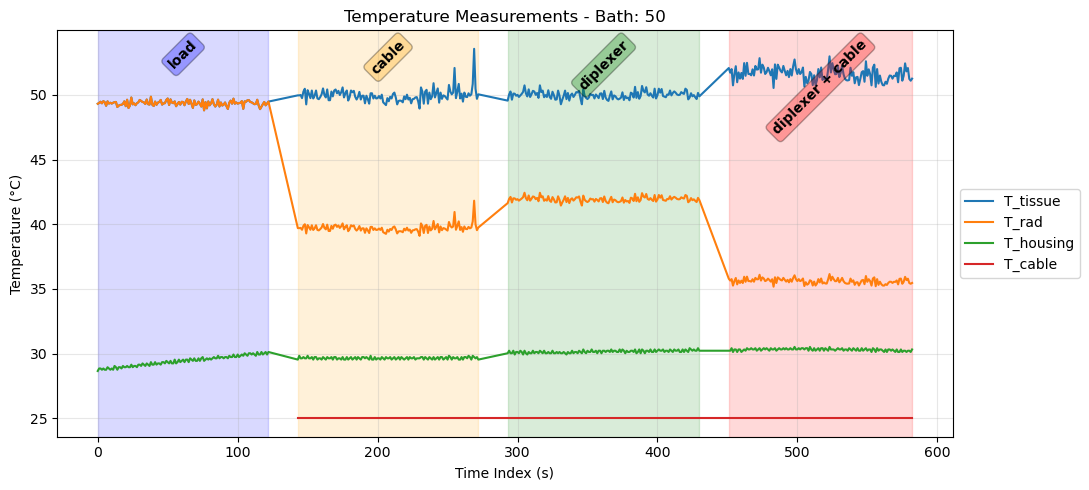

<Figure size 640x480 with 0 Axes>

In [122]:
variables = ['T_tissue', 'T_rad', 'T_housing', 'T_cable']
plot_all_conditions(
    all_X_clean,
    variables,
    labels,
    class_order,
    class_colors,
    gap_duration=20,
    cooling_flag_col='cooling_flag_2',
    time_index_col='time_index_2',
    yscale=1,
    title_prefix="Temperature Measurements - Bath: ",
    ylabel="Temperature (°C)"
)

In [123]:
# Calculate average Temperature for each condition and class
print("Average temperatures by condition and class:")
print("="*50)

for condition in sorted(all_X_clean['condition'].unique()):
    print(f"\nCondition: {condition}")
    condition_data = all_X_clean[all_X_clean['condition'] == condition]
    avg_temperatures = condition_data.groupby('class')[['T_rad', 'T_housing', 'T_tissue']].mean()

    print("Microvolts:")
    print(avg_temperatures.round(1))
    print("-" * 30)

Average temperatures by condition and class:

Condition: 50
Microvolts:
                  T_rad  T_housing  T_tissue
class                                       
cable              39.7       29.6      50.0
diplexer           41.9       30.2      50.0
diplexer + cable   35.6       30.3      51.6
load               49.4       29.4      49.4
------------------------------
